In [1]:
import sys
sys.path.append('../cdsd')
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from data import *
import jams
%matplotlib inline

Double check the mAP and accuracy, and co-occurence
Listen to some examples
Look at masks converge during training, and also after (compare with ideal masks)

Leakage from other classes to jackhammer

Gunshot and dog bark should do very well

Also listen to examples

As a last result, frame-level results

Double check loss masking
Double check data pipeline


126K audio files
504K mask files

Potential Issues
* Scaper causing distortion in some sources? Maybe quantization noise?

In [21]:
#root_dir = "/home/jsondotload/projects/class-dependent-spl-decomposition/pishdadian2020-lambda5_soundscapes"
#train_config_path = "/home/jsondotload/projects/class-dependent-spl-decomposition/config.json"
root_dir = "/beegfs/jtc440/cdsd-data/pishdadian2020-lambda5_soundscapes"
train_config_path = "/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frozen/config.json"
subset = 'test'

In [3]:
with open(train_config_path, 'r') as f:
    train_config = json.load(f)

In [26]:

input_transform = get_data_transforms(train_config)
test_dataset = CDSDDataset(root_dir, subset=subset, transform=input_transform, load_separation_data=True)

In [27]:
test_dataset.labels

['car_horn', 'dog_bark', 'gun_shot', 'jackhammer', 'siren']

In [28]:
test_dataset[0].keys()

dict_keys(['audio_data', 'labels', 'index', 'num_events', 'mixture_waveform', 'car_horn_waveform', 'dog_bark_waveform', 'gun_shot_waveform', 'jackhammer_waveform', 'siren_waveform', 'car_horn_transformed', 'dog_bark_transformed', 'gun_shot_transformed', 'jackhammer_transformed', 'siren_transformed'])

# Examine isolated sources

In [31]:
ex_idx = 4
normalize = True
sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]
print("File: " + fname)
print("============================================================")
print("Mixture:")
display(Audio(data=sample['mixture_waveform'], rate=SAMPLE_RATE, normalize=normalize))

print("\nPresent Sources")
print("------------------")
for label_idx in sample['labels'].nonzero().flatten().tolist():
    label = test_dataset.labels[label_idx]
    print(label + ":")
    display(Audio(data=4*sample[label + '_waveform'], rate=SAMPLE_RATE, normalize=normalize))

print("\nMissing Sources")
print("------------------")
for label_idx in (1 - sample['labels']).nonzero().flatten().tolist():
    label = test_dataset.labels[label_idx]
    print(label + ":")
    display(Audio(data=sample[label + '_waveform'], rate=SAMPLE_RATE, normalize=normalize))


File: soundscape_test_pishdadidan2020_lambda5_2885
Mixture:



Present Sources
------------------
car_horn:


dog_bark:


gun_shot:



Missing Sources
------------------
jackhammer:


siren:


# Look at individual events

In [52]:
jams_path = os.path.join(root_dir, subset, fname + '.jams')

In [53]:
jams_obj = jams.load(jams_path)

In [54]:
jams_obj

duration,4.0
original_duration,4.0
fg_path,/beegfs/jtc440/cdsd-data/us8k-foreground/test
bg_path,/beegfs/jtc440/sonyc_ust_spl_decomposition/background_clips_70/2017
fg_spec,choosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNonechoosecar_horndog_barkgun_shotjackhammersirenchooseconst0.0uniform0.04.0const4.0uniform-30-25foregroundNoneNone
bg_spec,
fg_labels,air_conditionercar_hornchildren_playingdog_barkdrillingengine_idlinggun_shotjackhammersirenstreet_music
bg_labels,sonycnode-b827eb0d8af7.sonyc_recording_indexsonycnode-b827eb0fedda.sonyc_recording_indexsonycnode-b827eb122f0f.sonyc_recording_indexsonycnode-b827eb132382.sonyc_recording_indexsonycnode-b827eb1685c7.sonyc_recording_indexsonycnode-b827eb241343.sonyc_recording_indexsonycnode-b827eb252949.sonyc_recording_indexsonycnode-b827eb29eb77.sonyc_recording_indexsonycnode-b827eb2a1bce.sonyc_recording_indexsonycnode-b827eb2c65db.sonyc_recording_indexsonycnode-b827eb329ab8.sonyc_recording_indexsonycnode-b827eb32e075.sonyc_recording_indexsonycnode-b827eb429cd4.sonyc_recording_indexsonycnode-b827eb42bd4a.sonyc_recording_indexsonycnode-b827eb43d8f4.sonyc_recording_indexsonycnode-b827eb44506f.sonyc_recording_indexsonycnode-b827eb4cc22e.sonyc_recording_indexsonycnode-b827eb4e7821.sonyc_recording_indexsonycnode-b827eb539980.sonyc_recording_indexsonycnode-b827eb5895e9.sonyc_recording_indexsonycnode-b827eb73e772.sonyc_recording_indexsonycnode-b827eb815321.sonyc_recording_indexsonycnode-b827eb820cfe.sonyc_recording_indexsonycnode-b827eb86d458.sonyc_recording_indexsonycnode-b827eb8e2420.sonyc_recording_indexsonycnode-b827eb905497.sonyc_recording_indexsonycnode-b827eb9b859c.sonyc_recording_indexsonycnode-b827eb9bed23.sonyc_recording_indexsonycnode-b827eb9d0e7f.sonyc_recording_indexsonycnode-b827ebad073b.sonyc_recording_indexsonycnode-b827ebb40450.sonyc_recording_indexsonycnode-b827ebba613d.sonyc_recording_indexsonycnode-b827ebc6dcc6.sonyc_recording_indexsonycnode-b827ebc7f772.sonyc_recording_indexsonycnode-b827ebdd5c38.sonyc_recording_indexsonycnode-b827ebe1fe4b.sonyc_recording_indexsonycnode-b827ebefb215.sonyc_recording_indexsonycnode-b827ebf31214.sonyc_recording_indexsonycnode-b827ebf9d204.sonyc_recording_indexsonycnode-b827ebfd616c.sonyc_recording_index
protected_labels,car_horndog_barkgun_shotjackhammersiren
sr,16000
ref_db,-50


In [84]:
import soundfile as sf
audio, sr = sf.read('../128470-3-0-5.wav')
audio = audio.mean(axis=-1).astype('float32')

In [95]:
original_scale = np.abs(audio).max()
target_scale = np.abs(sample['dog_bark_waveform'].numpy()).max()
rescaled_audio_1 = audio / original_scale
rescaled_audio_2 = rescaled_audio * target_scale

In [109]:
from scaper.audio import get_integrated_lufs

In [111]:
-78.22176208650802 - get_integrated_lufs('../128470-3-0-5.wav')

-64.22176208650802

In [114]:
Audio(audio, rate=sr)

In [112]:
audio_rs, sr = sf.read('../rescaled_dog.wav')
audio_rs = audio_rs.mean(axis=-1)
Audio(audio_rs, rate=sr)

In [106]:
dog_path = os.path.join(root_dir, subset, fname + "_events", "foreground2_dog_bark.wav")
audio2, sr = sf.read(dog_path)
Audio(audio2, rate=SAMPLE_RATE)

In [98]:
Audio(rescaled_audio_2, rate=SAMPLE_RATE)

# Double check distribution of events per clip

(5.0322, 4.82076316)


Text(0.5, 1.0, 'Distribution of events')

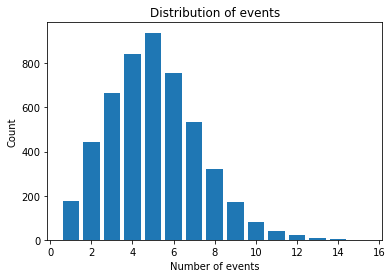

In [13]:
num_events_list = [int(x['num_events'].item()) for x in test_dataset]
vals = sorted(set(num_events_list))
counts = {x: 0 for x in vals}
for x in num_events_list:
    counts[x] += 1
counts = [counts[x] for x in vals]

print((np.mean(num_events_list), np.var(num_events_list)))

plt.bar(vals, counts)
plt.xlabel('Number of events')
plt.ylabel('Count')
plt.title('Distribution of events')

Text(0.5, 1.0, 'Empirical distribution of zero-truncated Poisson (lambda = 5)')

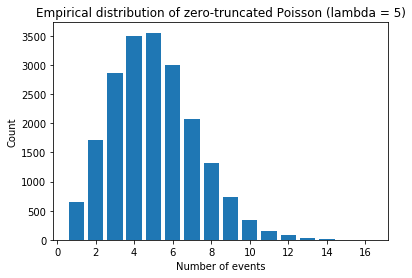

In [45]:
from generate_mixtures import sample_ztpoisson
ztp_counts = {}
ztp_max = 0
lmbda = 5
for _ in range(20000):
    x = sample_ztpoisson(lmbda)
    if x not in ztp_counts:
        ztp_counts[x] = 1
    else:
        ztp_counts[x] += 1
        
    ztp_max = max(x, ztp_max)
    
for x in range(1, ztp_max + 1):
    if x not in ztp_counts:
        ztp_counts[x] = 0
ztp_counts = [ztp_counts[x] for x in np.arange(1, ztp_max+1)]
plt.bar(np.arange(1, ztp_max+1), ztp_counts)
plt.xlabel('Number of events')
plt.ylabel('Count')
plt.title('Empirical distribution of zero-truncated Poisson (lambda = {})'.format(lmbda))

# Double check the distribution of event types per example

(3.179, 1.108559)


Text(0.5, 1.0, 'Distribution of event types')

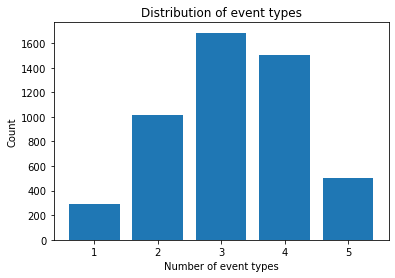

In [49]:
num_event_type_list = [int(x['labels'].sum().item()) for x in test_dataset]

vals = sorted(set(num_event_type_list))
counts = {x: 0 for x in vals}
for x in num_event_type_list:
    counts[x] += 1
counts = [counts[x] for x in vals]

print((np.mean(num_event_type_list), np.var(num_event_type_list)))

plt.bar(vals, counts)
plt.xlabel('Number of event types')
plt.ylabel('Count')
plt.title('Distribution of event types')

# Check frame level probabilities for each class

In [22]:
input_transform = get_data_transforms(train_config)
train_dataset = CDSDDataset(root_dir, subset='train', transform=input_transform, load_separation_data=True, label_mode='frame')

In [23]:
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram, MelScale, Spectrogram

In [32]:
total_num_frames = 0
label_frame_counts = None
num_events_list = []

for file in train_dataset.files:
    jams_path = os.path.join(root_dir, 'train', file + '.jams')
    jams_obj = jams.load(jams_path)

    hop_length = 1
    win_length = 1

    for t in input_transform.transforms:
        # There should only be at most one transform that
        # effects the time dimension (since we don't allow
        # the resample transformation)
        if isinstance(t, Spectrogram) or isinstance(MelSpectrogram):
            hop_length = t.hop_length
            win_length = t.win_length

    # Account for centering
    pad_ts = (win_length // 2) / SAMPLE_RATE

    hop_ts = hop_length / SAMPLE_RATE
    num_frames = 501

    label_arr = torch.zeros(num_frames, train_dataset.num_labels)
    num_events = torch.zeros(1, dtype=torch.int16)
    for ann in jams_obj.annotations[0].data:
        if ann.value['role'] == "foreground":
            start_ts = ann.value['event_time']
            end_ts = start_ts + ann.value['event_duration']

            # Compute frame indices, such that each frame contains
            # the source
            start_idx = int((start_ts - pad_ts + hop_ts) * SAMPLE_RATE / hop_length)
            start_idx = max(0, start_idx)
            end_idx = int(np.ceil((end_ts + pad_ts) * SAMPLE_RATE / hop_length))
            end_idx = min(num_frames, end_idx)


            label = ann.value['label']
            label_idx = train_dataset.label_to_idx[label]
            label_arr[start_idx:end_idx, label_idx] = 1.0
            num_events += 1
            
    total_num_frames += x['labels'].shape[0]
    ex_counts = label_arr.sum(axis=0).numpy()
    if label_frame_counts is None:
        label_frame_counts = ex_counts
    else:
        label_frame_counts += ex_counts
        
    num_events_list.append(num_events.item())
label_frame_probs = label_frame_counts / total_num_frames

In [20]:
label_frame_probs

array([0.38827545, 0.53760709, 0.31754182, 0.59567595, 0.61354651])

(5.0588, 4.83264256)


Text(0.5, 1.0, 'Distribution of events')

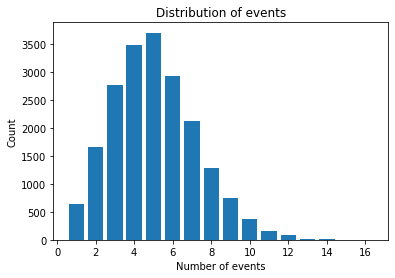

In [33]:
vals = sorted(set(num_events_list))
counts = {x: 0 for x in vals}
for x in num_events_list:
    counts[x] += 1
counts = [counts[x] for x in vals]

print((np.mean(num_events_list), np.var(num_events_list)))

plt.bar(vals, counts)
plt.xlabel('Number of events')
plt.ylabel('Count')
plt.title('Distribution of events')

# Double check frame-level targets

In [264]:
import numpy as np
from interval import interval

sample_rate = 16000
clip_duration_ts = 4.0

event_start_ts = 0.777777
event_end_ts = 2.2353457
event_interval = interval[event_start_ts, event_end_ts]

hop_length = 128
win_length = 512

# Construct test signal
test_arr = np.zeros((int(sample_rate * clip_duration_ts),))

# Pad for centering
pad = win_length // 2
test_arr = np.pad(test, (pad, pad))

pad_ts = pad / SAMPLE_RATE
hop_ts = hop_length / SAMPLE_RATE
win_ts = win_length / SAMPLE_RATE

num_frames = (test.shape[0] - win_length) // hop_length + 1


# Compute intersections of frame intervals with event intervals
test_y1 = np.zeros((num_frames,))
flag = True
for frame_idx in range(num_frames):
    frame_start_ts = frame_idx * hop_ts - pad_ts
    frame_end_ts = frame_start_ts + win_ts
    
    frame_interval = interval[frame_start_ts, frame_end_ts]
    intersection = (frame_interval & event_interval)
    if len(intersection.extrema) > 1:
        #print(frame_idx, frame_start_ts, frame_end_ts, intersection)
        test_y1[frame_idx] = 1
        
frame_start_idx_1, frame_end_idx_1 = test_y1.nonzero()[0][[0, -1]]
print((frame_start_idx_1, frame_end_idx_1 + 1))


frame_start_idx = int((event_start_ts - pad_ts + hop_ts) * sample_rate / hop_length)
frame_start_idx = max(0, frame_start_idx)

frame_end_idx = int(np.ceil((event_end_ts + pad_ts) * sample_rate / hop_length))
frame_end_idx = min(num_frames, frame_end_idx)
print((frame_start_idx, frame_end_idx))


(96, 282)
(96, 282)


# Check energy masking

In [22]:
from librosa.display import specshow

Text(0, 0.5, '            ')

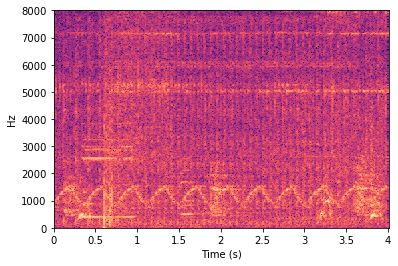

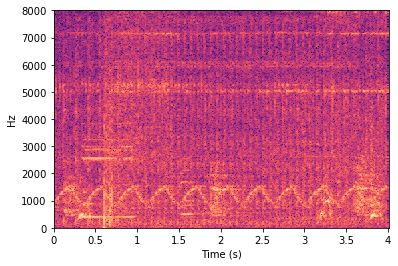

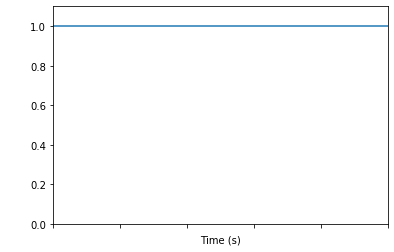

In [69]:
# Get example
idx_list = []
for ex_idx in range(len(test_dataset)):
    x = test_dataset[ex_idx]['audio_data'][None, ...]
    # Compute mask
    batch_size, n_channel, n_freq, n_time = x.size()
    frame_energy = x.sum(dim=2, keepdim=True)
    threshold = frame_energy.max(dim=3, keepdim=True)[0] * 0.01
    energy_mask = (frame_energy >= threshold).float()

    if (energy_mask < 0.5).max().item():
        idx_list.append(ex_idx)


Text(0, 0.5, '            ')

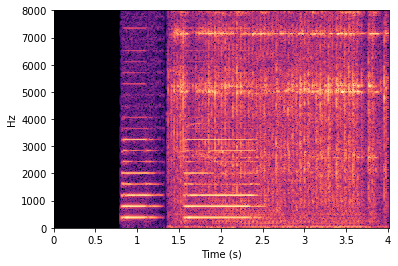

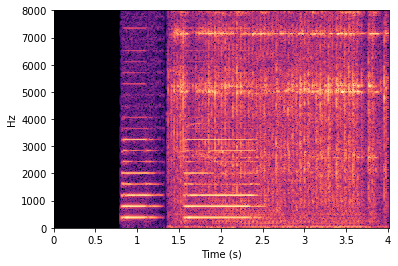

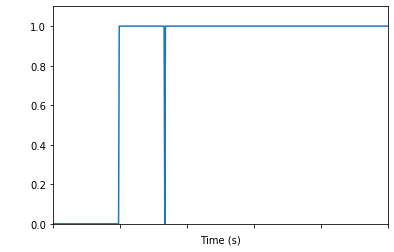

In [74]:
ex_idx = idx_list[3]

sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]

#display(Audio(data=sample['mixture_waveform'], rate=SAMPLE_RATE, normalize=normalize))
spec = sample['audio_data']
logspec_np = librosa.amplitude_to_db(spec.squeeze().numpy())


x = spec[None, ...]

# Compute mask
batch_size, n_channel, n_freq, n_time = x.size()

frame_energy = x.sum(dim=2, keepdim=True)
threshold = frame_energy.max(dim=3, keepdim=True)[0] * 0.01
energy_mask = (frame_energy >= threshold).float()
mix_energy = (x * energy_mask).view(batch_size, -1)
mix_logspec_np = librosa.amplitude_to_db(x.squeeze().numpy())


# Visualize mask vs spectrogram
fig = plt.figure()
ax = plt.gca()
specshow(logspec_np, sr=SAMPLE_RATE, y_axis='linear', hop_length=128, x_axis='s', ax=ax)

fig = plt.figure()
ax = plt.gca()
specshow(mix_logspec_np, sr=SAMPLE_RATE, y_axis='linear', hop_length=128, x_axis='s', ax=ax)

xticklabels = ax.get_xticklabels()

fig = plt.figure()
ax = plt.gca()

ax.plot(energy_mask.squeeze().numpy())
ax.set_ylim([0, 1.1])
ax.set_xlim([0, 500])
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Time (s)')
ax.set_ylabel('            ', rotation=0)

In [72]:
len(idx_list)

459

# Inspect masking of loss

In [79]:
import torch

In [89]:
input_transform = get_data_transforms(train_config)
test_dataset = CDSDDataset(root_dir, subset=subset, transform=input_transform, load_separation_data=True)
ex_idx = idx_list[3]

sample = test_dataset[ex_idx]
fname = test_dataset.files[ex_idx]

#display(Audio(data=sample['mixture_waveform'], rate=SAMPLE_RATE, normalize=normalize))
spec = sample['audio_data']
num_labels = len(test_dataset.labels)

x = spec[None, ...]
labels = sample['labels'][None, ...]
masks = torch.ones(x.size() + (num_labels,))
batch_size, n_channel, n_freq, n_time = x.size()

frame_energy = x.sum(dim=2, keepdim=True)
threshold = frame_energy.max(dim=3, keepdim=True)[0] * 0.01
energy_mask = (frame_energy >= threshold).float()
mix_energy = (x * energy_mask).view(batch_size, -1)

present_energy = torch.zeros_like(mix_energy)
absent_energy = torch.zeros_like(mix_energy)

for idx in range(num_labels):
    mask = masks[..., idx]
    x_masked = x * mask
    x_masked = x_masked * energy_mask

    present_energy += x_masked.view(batch_size, -1) * labels[:, idx:idx+1]
    absent_energy += x_masked.view(batch_size, -1) * (1 - labels[:, idx:idx+1])



present_loss = torch.norm(mix_energy - present_energy, p=1, dim=1)
absent_loss = torch.norm(absent_energy, p=1, dim=1)
mix_loss = (present_loss + absent_loss).mean()

../cdsd/data.py:41: UserWarning: Could not find subset train in /home/jsondotload/projects/class-dependent-spl-decomposition/pishdadian2020-lambda5_soundscapes. Skipping.
  warnings.warn('Could not find subset {} in {}. Skipping.'.format(subset, root_dir))
../cdsd/data.py:41: UserWarning: Could not find subset valid in /home/jsondotload/projects/class-dependent-spl-decomposition/pishdadian2020-lambda5_soundscapes. Skipping.
  warnings.warn('Could not find subset {} in {}. Skipping.'.format(subset, root_dir))


In [95]:
labels

tensor([[1., 0., 0., 1., 0.]])

In [107]:
class_idx = 4
(x_masked.view(batch_size, -1) * (1 - labels[:, class_idx:class_idx+1])).max()

tensor(0.0356)

# Inspect models



In [113]:
from models import BLSTMSpectrogramSeparator, CRNNSpectrogramClassifier

In [114]:
n_bins = 257
n_classes = len(test_dataset.labels)
bias = True
input_transform

separator = BLSTMSpectrogramSeparator(n_bins, n_classes, bias=bias, transform=input_transform)
classifier = CRNNSpectrogramClassifier(n_bins, n_classes, bias=bias, transform=input_transform)

In [115]:
print(separator)
print()
print(classifier)

BLSTMSpectrogramSeparator(
  (blstm): LSTM(257, 600, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1200, out_features=1285, bias=True)
)

CRNNSpectrogramClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (blstm): LSTM(4096, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
)
